# Importing packages

In [1]:
import gc
import os
import time
import pywt
import logging
import datetime
import warnings
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import pandas as pd
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import seaborn as sns
import xgboost as xgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

# Processing train data

In [2]:
%%time
train_df = pd.read_csv("LANL-Earthquake-Prediction/train.csv",
                       dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1min 15s, sys: 6.47 s, total: 1min 21s
Wall time: 1min 14s


In [3]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


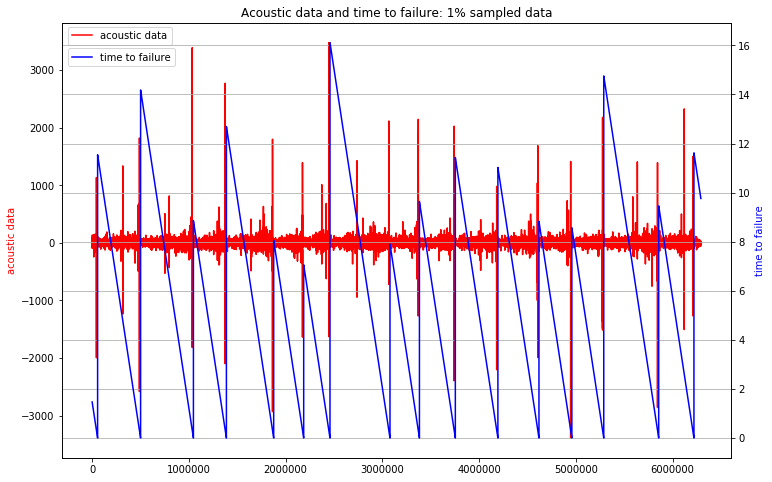

In [4]:
train_ad_sample_df = train_df['acoustic_data'].values[::100]
train_ttf_sample_df = train_df['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

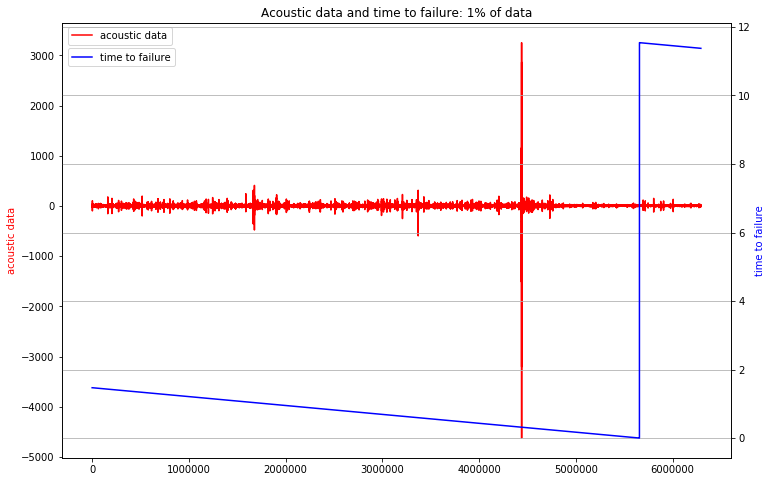

In [5]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

In [ ]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

In [6]:
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)
    # Copy for LTA
    lta = sta.copy()
    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta
    # Pad zeros
    sta[:length_lta - 1] = 0
    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny
    return sta / lta

In [ ]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [7]:
def create_features(seg_id, seg, X):
    n_freq = 4
    w_window = 5000 # averaging window for transformed data
    n_rows = seg.shape[0] 
    n_w_windows = int(n_rows / w_window)
    
    xc = pd.Series(seg['acoustic_data'].values)
    [yc_morl, _] = pywt.cwt(xc, np.arange(1, n_freq), 'cmor')
    [yc_mexh, _] = pywt.cwt(xc, np.arange(1, n_freq), 'mexh')
    
    zc = np.fft.fft(xc)
    
    #Standard features
    X.loc[seg_id, 'mean'] = xc.mean()
    X.loc[seg_id, 'std'] = xc.std()
    X.loc[seg_id, 'max'] = xc.max()
    X.loc[seg_id, 'min'] = xc.min()
    X.loc[seg_id, 'ave_min_max'] = (xc.min() + xc.max()) / 2
    
    
    #Morlet wavelet transform features
    for scale in range(n_freq - 1):
        for idx in range(n_w_windows):
            curr_real = np.real(yc_morl[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rmean'] = np.nanmean(curr_real)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rstd'] = np.nanstd(curr_real)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rmax'] = curr_real.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Rmin'] = curr_real.min()
            curr_imag = np.imag(yc_morl[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Imean'] = np.nanmean(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Istd'] = np.nanstd(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Imax'] = curr_imag.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'morl' + 'Imin'] = curr_imag.min()
            
            curr_real = np.real(yc_mexh[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rmean'] = np.nanmean(curr_real)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rstd'] = curr_real.std()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rmax'] = curr_real.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Rmin'] = curr_real.min()
            curr_imag = np.imag(yc_mexh[scale][idx * w_window : (idx + 1) * w_window])
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Imean'] = np.nanmean(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Istd'] = np.nanstd(curr_imag)
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Imax'] = curr_imag.max()
            X.loc[seg_id, str(scale) + '_' + str(idx) + 'mexh' + 'Imin'] = curr_imag.min()

            

    #FFT transform values
    realFFT = np.real(zc)
    imagFFT = np.imag(zc)
    X.loc[seg_id, 'Rmean'] = realFFT.mean()
    X.loc[seg_id, 'Rstd'] = realFFT.std()
    X.loc[seg_id, 'Rmax'] = realFFT.max()
    X.loc[seg_id, 'Rmin'] = realFFT.min()
    X.loc[seg_id, 'Imean'] = imagFFT.mean()
    X.loc[seg_id, 'Istd'] = imagFFT.std()
    X.loc[seg_id, 'Imax'] = imagFFT.max()
    X.loc[seg_id, 'Imin'] = imagFFT.min()
    X.loc[seg_id, 'Rmean_last_5000'] = realFFT[-5000:].mean()
    X.loc[seg_id, 'Rstd__last_5000'] = realFFT[-5000:].std()
    X.loc[seg_id, 'Rmax_last_5000'] = realFFT[-5000:].max()
    X.loc[seg_id, 'Rmin_last_5000'] = realFFT[-5000:].min()
    X.loc[seg_id, 'Rmean_last_15000'] = realFFT[-15000:].mean()
    X.loc[seg_id, 'Rstd_last_15000'] = realFFT[-15000:].std()
    X.loc[seg_id, 'Rmax_last_15000'] = realFFT[-15000:].max()
    X.loc[seg_id, 'Rmin_last_15000'] = realFFT[-15000:].min()
    
    X.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(xc))
    X.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(xc) / xc[:-1]))[0])
    X.loc[seg_id, 'abs_max'] = np.abs(xc).max()
    X.loc[seg_id, 'abs_min'] = np.abs(xc).min()
    
    X.loc[seg_id, 'std_first_50000'] = xc[:50000].std()
    X.loc[seg_id, 'std_last_50000'] = xc[-50000:].std()
    X.loc[seg_id, 'std_first_10000'] = xc[:10000].std()
    X.loc[seg_id, 'std_last_10000'] = xc[-10000:].std()
    
    X.loc[seg_id, 'avg_first_50000'] = xc[:50000].mean()
    X.loc[seg_id, 'avg_last_50000'] = xc[-50000:].mean()
    X.loc[seg_id, 'avg_first_10000'] = xc[:10000].mean()
    X.loc[seg_id, 'avg_last_10000'] = xc[-10000:].mean()
    
    X.loc[seg_id, 'min_first_50000'] = xc[:50000].min()
    X.loc[seg_id, 'min_last_50000'] = xc[-50000:].min()
    X.loc[seg_id, 'min_first_10000'] = xc[:10000].min()
    X.loc[seg_id, 'min_last_10000'] = xc[-10000:].min()
    
    X.loc[seg_id, 'max_first_50000'] = xc[:50000].max()
    X.loc[seg_id, 'max_last_50000'] = xc[-50000:].max()
    X.loc[seg_id, 'max_first_10000'] = xc[:10000].max()
    X.loc[seg_id, 'max_last_10000'] = xc[-10000:].max()
    
    X.loc[seg_id, 'max_to_min'] = xc.max() / np.abs(xc.min())
    X.loc[seg_id, 'max_to_min_diff'] = xc.max() - np.abs(xc.min())
    X.loc[seg_id, 'count_big'] = len(xc[np.abs(xc) > 500])
    X.loc[seg_id, 'sum'] = xc.sum()
    
    X.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(xc[:50000]) / xc[:50000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(xc[-50000:]) / xc[-50000:][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(xc[:10000]) / xc[:10000][:-1]))[0])
    X.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(xc[-10000:]) / xc[-10000:][:-1]))[0])
    
    X.loc[seg_id, 'q95'] = np.quantile(xc, 0.95)
    X.loc[seg_id, 'q99'] = np.quantile(xc, 0.99)
    X.loc[seg_id, 'q05'] = np.quantile(xc, 0.05)
    X.loc[seg_id, 'q01'] = np.quantile(xc, 0.01)
    
    X.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(xc), 0.95)
    X.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(xc), 0.99)
    X.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(xc), 0.05)
    X.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(xc), 0.01)
    
    X.loc[seg_id, 'trend'] = add_trend_feature(xc)
    X.loc[seg_id, 'abs_trend'] = add_trend_feature(xc, abs_values=True)
    X.loc[seg_id, 'abs_mean'] = np.abs(xc).mean()
    X.loc[seg_id, 'abs_std'] = np.abs(xc).std()
    
    X.loc[seg_id, 'mad'] = xc.mad()
    X.loc[seg_id, 'kurt'] = xc.kurtosis()
    X.loc[seg_id, 'skew'] = xc.skew()
    X.loc[seg_id, 'med'] = xc.median()
    
    X.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(xc)).mean()
    X.loc[seg_id, 'Hann_window_mean'] = (convolve(xc, hann(150), mode='same') / sum(hann(150))).mean()
    X.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(xc, 500, 10000).mean()
    X.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(xc, 5000, 100000).mean()
    X.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(xc, 3333, 6666).mean()
    X.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(xc, 10000, 25000).mean()
    X.loc[seg_id, 'Moving_average_700_mean'] = xc.rolling(window=700).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_1500_mean'] = xc.rolling(window=1500).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_3000_mean'] = xc.rolling(window=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'Moving_average_6000_mean'] = xc.rolling(window=6000).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(xc, span=300).mean()).mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(xc, span=3000).mean().mean(skipna=True)
    X.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(xc, span=6000).mean().mean(skipna=True)
    no_of_std = 2
    X.loc[seg_id, 'MA_700MA_std_mean'] = xc.rolling(window=700).std().mean()
    X.loc[seg_id,'MA_700MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id,'MA_700MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X.loc[seg_id, 'MA_400MA_std_mean'] = xc.rolling(window=400).std().mean()
    X.loc[seg_id,'MA_400MA_BB_high_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id,'MA_400MA_BB_low_mean'] = (X.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X.loc[seg_id, 'MA_1000MA_std_mean'] = xc.rolling(window=1000).std().mean()
    
    X.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(xc, [75, 25]))
    X.loc[seg_id, 'q999'] = np.quantile(xc,0.999)
    X.loc[seg_id, 'q001'] = np.quantile(xc,0.001)
    X.loc[seg_id, 'ave10'] = stats.trim_mean(xc, 0.1)
    
    for windows in [10, 100, 1000, 10000]:
        x_roll_std = xc.rolling(windows).std().dropna().values
        x_roll_mean = xc.rolling(windows).mean().dropna().values
        
        X.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

In [ ]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [ ]:
train_X = pd.read_csv("features_150k_with_wavelets")
train_y = pd.read_csv("labels_150k_with_wavelets")

In [ ]:
train_X.shape

In [ ]:
train_X.to_csv("features_150k_with_wavelets", index=False)
train_y.to_csv("labels_150k_with_wavelets", index=False)

In [ ]:
train_X.head(10)

In [ ]:
train_X.fillna(0);

In [ ]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)

In [ ]:
scaled_train_X.head(10)

In [ ]:
scaled_train_X.columns

We also create a feature matrix each row of which aggregates information from 30k signal points

In [8]:
rows = 30000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  20971


In [9]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])
total_mean = train_df['acoustic_data'].mean()
total_std = train_df['acoustic_data'].std()
total_max = train_df['acoustic_data'].max()
total_min = train_df['acoustic_data'].min()
total_sum = train_df['acoustic_data'].sum()
total_abs_sum = np.abs(train_df['acoustic_data']).sum()

In [ ]:
# iterate over all segments
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg, train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]

In [13]:
scaler_30k = StandardScaler()
scaler_30k.fit(train_X)
scaled_train_X = pd.DataFrame(scaler_30k.transform(train_X), columns=train_X.columns)

In [14]:
train_X.to_csv("features_30k_with_wavelets", index=False)
train_y.to_csv("labels_30k_with_wavelets", index=False)

In [2]:
train_X = pd.read_csv("features_30k_with_wavelets")
train_y = pd.read_csv("labels_30k_with_wavelets")

# Processing test data

In [ ]:
submission = pd.read_csv('LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
test_X = pd.DataFrame(columns=train_X.columns, dtype=np.float64, index=submission.index)

In [ ]:
submission.shape, test_X.shape

In [ ]:
for seg_id in tqdm_notebook(test_X.index):
    seg = pd.read_csv('LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    create_features(seg_id, seg, test_X)

In [ ]:
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

# Baseline approach

In [ ]:
y_ave = train_y.mean()['time_to_failure']
baseline_error = mean_absolute_error(np.ones_like(train_y) * y_ave, train_y)

In [ ]:
print('Baseline method gives mean absolute error', baseline_error)

# Tuning XGBoost parameters

In [ ]:
def modelfit(alg, train_x, train_y, useTrainCV=True, cv_folds=5, early_stopping_rounds=50, show_values=30):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_x.values, label=train_y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds, show_stdv=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_x, train_y,eval_metric='mae')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train_x)
        
    #Print model report:
    print("\nModel Report")
    print("Mean absolute error : {}".format(mean_absolute_error(train_y, dtrain_predictions)))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:show_values]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
xgtrain = xgb.DMatrix(train_X.values, label=train_y.values)

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.1,
    'min_child_weight' : 1,
    'subsample' : 0.8,
    'max_depth' : 5,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_1 = {
 'max_depth' : range(3, 10, 2),
 'min_child_weight' : range(1, 6, 2)
}

gsearch_1 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_1, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_1.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_1.cv_results_)

In [ ]:
gsearch_1.best_params_, gsearch_1.best_score_

In [ ]:
param_test_2 = {
 'max_depth' : range(8, 12),
 'min_child_weight' : range(1, 4)
}

gsearch_2 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_2, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_2.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_2.cv_results_)

In [ ]:
gsearch_2.best_params_, gsearch_2.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.1,
    'min_child_weight' : 1,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_3 = {
 'min_child_weight' : range(1, 6)
}

gsearch_3 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_3, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_3.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_3.cv_results_)

In [ ]:
gsearch_3.best_params_, gsearch_3.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.1,
    'min_child_weight' : 2,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_4 = {
 'gamma' : np.linspace(0, 0.5, 10)
}

gsearch_4 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_4, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_4.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_4.cv_results_)

In [ ]:
gsearch_4.best_params_, gsearch_4.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 140,
    'n_jobs' : 10,
    'seed' : 27
}

Let us recalibrate number of estimators.

In [ ]:
alg = xgb.XGBRegressor(**params)

In [ ]:
modelfit(alg, scaled_train_X, train_y, cv_folds=5, early_stopping_rounds=50)

In [ ]:
alg.get_params

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.8,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.8,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 5,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_5 = {
 'subsample' : [i/10.0 for i in range(6,10)],
 'colsample_bytree' : [i/20.0 for i in range(1,20)]
}

gsearch_5 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_5, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_5.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_5.cv_results_)

In [ ]:
gsearch_5.best_params_, gsearch_5.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 5,
    'n_jobs' : 10,
    'seed' : 27
}

In [ ]:
param_test_6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch_6 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_6, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_6.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_6.cv_results_)

In [ ]:
gsearch_6.best_params_, gsearch_6.best_score_

In [ ]:
param_test_7 = {
    'reg_alpha': np.arange(100, 12000, 100)
}

gsearch_7 = GridSearchCV(estimator = xgb.XGBRegressor(**params), 
                        param_grid = param_test_7, scoring='neg_mean_absolute_error', n_jobs=10, iid=False, cv=5)

gsearch_7.fit(scaled_train_X, train_y)

pd.DataFrame(gsearch_7.cv_results_)

In [ ]:
gsearch_7.best_params_, gsearch_7.best_score_

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_estimators' : 1000,
    'n_jobs' : 10,
    'seed' : 27,
    'reg_alpha' : 400 
}

In [ ]:
alg = xgb.XGBRegressor(**params)
modelfit(alg, scaled_train_X, train_y, show_values=50)

In [ ]:
alg.get_params

In [ ]:
params = {
    'objective' : 'reg:linear',
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.4,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_jobs' : 10,
    'seed' : 27,
    'reg_alpha' : 400 
}

Adjusting parameters manually

In [ ]:
params = {
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.05,
    'gamma' : 0.5,
    'min_child_weight' : 2,
    'subsample' : 0.9,
    'max_depth' : 10,
    'scale_pos_weight' : 1,
    'tree_method' : 'exact',
    'n_jobs' : 20,
    'seed' : 27,
    'reg_alpha' : 0.75,
    'n_estimators' : 85
}

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [ ]:
maer = 0
reg_alphas = np.linspace(0, 1, 9)
counter = 0
for reg_alpha in reg_alphas:
    aggr_val = 0
    aggr_tr = 0
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(scaled_train_X,train_y.values)):
        strLog = "fold {}".format(fold_)
        # print(strLog)

        X_tr, X_val = scaled_train_X.iloc[trn_idx], scaled_train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

        model = xgb.XGBRegressor(**params, reg_alpha=reg_alpha)
        model.fit(X_tr, 
                  y_tr,
                  eval_metric='rmse',
                 )
        aggr_tr += mean_absolute_error(model.predict(X_tr), y_tr)
        aggr_val += mean_absolute_error(model.predict(X_val), y_val)
        # print('tr_loss', maer_tr, ': val_loss', maer)
    print(counter, ': prm_value =', reg_alpha, ': tr_loss :', aggr_tr / n_fold, ', val_loss :', aggr_val / n_fold)
    counter += 1

Training final model

In [ ]:
xgb_final = xgb.XGBRegressor(**params)
xgb_final.fit(scaled_train_X, train_y)
predictions_xgb = xgb_final.predict(scaled_test_X)

In [ ]:
# submission['time_to_failure'] = predictions_xgb
# submission.to_csv('xbg_only_prediction_subm')
# submission.head()

# RNN 

In [3]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available')

No GPU available
